In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def atmo_event_rate_fit(data, params):
    sin2theta, dm2 = params
    energy, cosdec = data
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    rows = []
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            i=i+1
            rows.append([e,c,int(event_random)])
    events_df = pd.DataFrame(rows, columns=['energy','cosdec','events'])
    return events_df

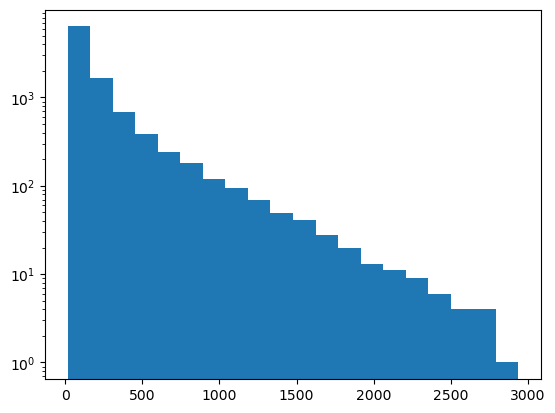

,energy,cosdec,events
0,10.0,0.000000,1951
1,10.0,0.010101,1905
2,10.0,0.020202,1958
3,10.0,0.030303,1837
4,10.0,0.040404,1752
...,...,...,...
9995,100.0,0.959596,23
9996,100.0,0.969697,35
9997,100.0,0.979798,24
9998,100.0,0.989899,31


In [3]:
def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    energy = 10**np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    
    events_df = run_experiment(energy,cosdec,sin2theta,dm2)
    
    return events_df

events_df = generate_data(100)

plt.hist(events_df["events"], bins=20)
plt.yscale('log')

plt.show() 
events_df

In [4]:
from iminuit import Minuit


def atmo_event_rate_fit(data, sin2theta, dm2):
    energy, cosdec = data[0,:], data[1,:]
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

events_df_ = generate_data(100, sin2theta=0.75, dm2=1.2e-3)

popt, pcov = curve_fit(atmo_event_rate_fit, xdata=np.vstack((events_df_["energy"], events_df_["cosdec"])), ydata=events_df_["events"], p0=[0.5, 1e-3])
perr = np.sqrt(np.diag(pcov))

print(f"Best fit sin2theta: {popt[0]:.3e} +/- {perr[0]:.3e}")
print(f"Best fit dm2: {popt[1]:.3e} +/- {perr[1]:.3e}")


Best fit sin2theta: 7.495e-01 +/- 6.857e-04
Best fit dm2: 1.206e-03 +/- 1.832e-06
